### Implementing DeepDream in Keras

All ImageNet trained Convnets can be used for DeepDream. The orginal Google implementation used Inception model, hence we will use InceptionV3 here.

#### Loading the pretrained Inception V3 model

In [1]:
#from keras.applications import inception_v3
#from keras import backend as k

from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# We wont be training the model, so this command disables all training specifc operations
K.set_learning_phase(0)
# Build the Inceptionv3 network without its convolutional base.
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

c:\users\522817\onedrive - cognizant\myworks\ml\project-dl-book\dog-vs-cat\envs\lib\site-packages\keras\backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


87924736/87910968 [==============================] - 10s 0us/step


#### Setting up the Deepdream configuration

In [2]:
# Dictionary mapping layer names toa coefficent quantifying how much the layer's activation contribute to the
# loss you will seek to maximize. Note that the layer names are hardcoded in the builtin Inception V3 application. 
# We can list all the layers names using model.summary()

layer_contributions = {
    'mixed2':0.2,
    'mixed3':3.,
    'mixed4':2.,
    'mixed5':1.5
}

#### Defining the loss to be maximized

In [5]:
# Dictinary that maps layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])
# We will define the loss by adding layer contribution to this scalar varibale
loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output # Retrive the layers output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    
    # Adds the L2 norm of the feature of a layer to the loss. We avoid border artifacts by only involving 
    # nonborders pixels in the loss
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling
    

#### Gradient Access Process

In [7]:

# This tensor hold the genrated image(Dream)
dream = model.input

# Computes the Graident of the dream with regard to the loss
grads = K.gradients(loss, dream)[0]
#grads = K.tf.GradientTape(loss, dream)[0]

# Normalizes the gradients (important trick)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Setup a keras function to retrieve the value of the loss and gradients, given an input image
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grad(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_value = outs[1]
    return loss_value, grad_value

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_value = eval_loss_and_grad(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print(f"... Loss value at {i} is: {loss_value}")
        x += step * grad_value
    return x

#### Auxilary functions

In [8]:
import scipy.misc
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
              float(size[0]) / img.shape[1],
              float(size[1]) / img.shape[2],
              1)
    return scipy.ndimage.zoom(img, factors, order=1)

def deprocess_image(x):
    
    """util funtion to convert a tensor into a vlaid image"""
    
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1,2, 0))
    else:
        # Undoes preprocessing that was performed by inception_v3.preprocess_input
        x = x.reshape((x.shape[1], x.shape[2], 3))
        
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# This function is not working as scipy.misc does not have imsave anymore
# A lot of fix tried but no luck
#def store_image(img, fname):
#    pil_img = deprocess_image(np.copy(img))
#    scipy.misc.imsave(fname, pil_img)

# ALternate function
def store_image(img, fname):
    pil_img = deprocess_image(np.copy(img))
    plt.imsave(fname, pil_img)
    
def preprocess_image(image_path):
    
    """Util function to open, resize and format pictures into tesnors that inceptionv3 can process"""
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

#### Running gradient ascent over differnt successive scales

In [17]:
import numpy as np

# Playing with these hyperparameters will let us achieve new effects
step = 0.01         # GA step size
num_octave = 3      # No of scales at which to run GA
octave_scale = 1.4  # Size ratio between scales
iterations = 20     # Nof of ascent steps to run at each scale
max_loss = 10.      # loss grows > 10, we'll interrupt the GA to avoid ugly artifacts
base_image_path = './base_image/hface.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]

# Prepare a list of shape tuples defining the different scales at which to run gradient ascent
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
# Reverse the list of shapes so they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resizes the Numpy array of the image to the smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print(f"Processing image shape: {shape}")
    # Scale up the dream image
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                         iterations=iterations,
                         step=step,
                         max_loss=max_loss)
    # Scales up the smaller version of the original image: it will be pixelated
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    
    # Compute the high quality version of the original image at this size
    same_size_original = resize_img(original_img, shape)
    
    # The difference between the two is the details that was lost whyen scaling up.
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    # Reinjects lost details into the dream
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    store_image(img, fname=f"dream_at_scale{str(shape)}.png")

store_image(img, fname='final_dream.png')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/522817/OneDrive - Cognizant/myWorks/ML/project-dl-book/DeepDream/base_image/hface.jpg'

In [44]:
# Display the generated DeepDream Images
import os
import ipyplot

def show_dream_images(file_path):
    image_path_list = []
    # The list of items
    files = os.listdir(file_path)
    for file in files:
        image_path_list.append(f"{file_path}/{file}")
    ipyplot.plot_images(image_path_list)
    
show_dream_images('./deepdream_image/test_outpu1')

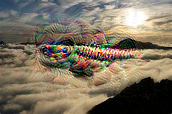

In [25]:
#Displaying an image
from IPython.display import Image
local_image1 = Image(filename='./deepdream_image/test_outpu1/dream_at_scale(114, 172).png')
local_image2 = Image(filename='./deepdream_image/test_outpu1/dream_at_scale(160, 242).png')
local_image3 = Image(filename='./deepdream_image/test_outpu1/dream_at_scale(225, 339).png')
local_image4 = Image(filename='./deepdream_image/test_outpu1/final_dream.png')
local_image1

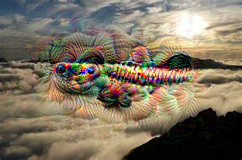

In [23]:
local_image2

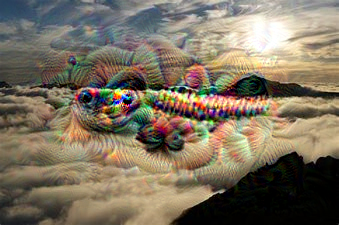

In [26]:
local_image3

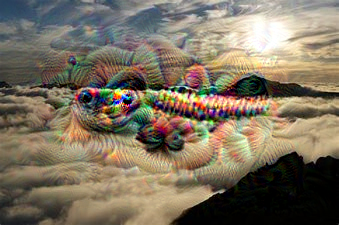

In [27]:
local_image4